# Regridding NARCliM 2.0 Climate Data to a Regular Latitude–Longitude Grid

This notebook demonstrates how to regrid NARCliM 2.0 climate model output from its
native rotated WRF grid (`rlat`, `rlon`) onto a regular latitude–longitude grid
using the xESMF regridding library.

The purpose of this notebook is to demonstrate the regridding of NARCliM 2.0
climate model output from its native rotated WRF grid to a regular
latitude–longitude grid. The focus is on the spatial transformation process,
resulting in gridded data suitable for regional-scale climate analysis and
visualisation.


## Background and Motivation

NARCliM 2.0 data are produced using the WRF regional climate model, which operates
on a **rotated latitude–longitude grid**. While this grid is well suited for
numerical modelling, it is not directly compatible with many downstream analysis
tasks. To address this, the data are regridded to a **regular latitude–longitude grid**
prior to analysis.


## Regridding methodology

This notebook uses **xESMF** to regrid climate model output from the native
regional climate model grid to a regular latitude–longitude grid.

xESMF provides several regridding algorithms, each with different trade-offs
between accuracy, conservation, and smoothness.

Commonly used methods include:

- **bilinear** – smooth interpolation, fast, not conservative
- **nearest_s2d / nearest_d2s** – nearest neighbour mapping
- **conservative / conservative_normed** – preserves integrals (e.g. precipitation totals)
- **patch** – higher-order interpolation

In this notebook, we use the *bilinear* method as a default for visualisation
and exploratory analysis.

For a detailed comparison of regridding algorithms, see the official xESMF
documentation:
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html


In [1]:
import xarray as xr
import numpy as np
import xesmf as xe
from pathlib import Path


## Data Access

The NARCliM dataset is accessed directly from the NCI THREDDS server using the
OpenDAP protocol and the `xarray` library. This approach avoids local downloads
and enables lightweight, reproducible workflows suitable for demonstration and
exploratory analysis.

The dataset used here is monthly maximum temperature (`tasmax`) from the
NARCliM 2.0 ensemble, but the workflow is applicable to any variable with
spatial dimensions.


In [2]:
url = (
    "https://dapds00.nci.org.au/thredds/dodsC/zz63/NARCliM2-0/output-CMIP6/DD/AUS-18/NSW-Government/ACCESS-ESM1-5/ssp126/r6i1p1f1/NARCliM2-0-WRF412R3/v1-r1/mon/tasmax/latest/tasmax_AUS-18_ACCESS-ESM1-5_ssp126_r6i1p1f1_NSW-Government_NARCliM2-0-WRF412R3_v1-r1_mon_201501-201512.nc"
)

ds = xr.open_dataset(url)
ds


<xarray.Dataset> Size: 10MB
Dimensions:    (time: 12, rlat: 321, rlon: 497, bnds: 2, crs: 1)
Coordinates:
  * time       (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T1...
  * rlat       (rlat) float64 3kB -22.88 -22.71 -22.53 ... 33.08 33.26 33.44
  * rlon       (rlon) float64 4kB -178.5 -178.3 -178.2 ... 178.2 178.3 178.5
  * crs        (crs) int32 4B 2143289344
    time_bnds  (time, bnds) datetime64[ns] 192B ...
    height     float64 8B ...
    lat        (rlat, rlon) float64 1MB ...
    lon        (rlat, rlon) float64 1MB ...
Dimensions without coordinates: bnds
Data variables:
    tasmax     (time, rlat, rlon) float32 8MB ...
Attributes: (12/43)
    project_id:                      CORDEX
    comment:                         DPIE version of WRF4.1.2
    DPIE_WRF_HASH:                   a051fdc73749349fd244ce8e596088a372bdb0c5
    wrf_options:                     sst_update & tmn_update
    frequency:                       mon
    git_url_postprocessing:          git@bitbucket.org:oehcas/cordex_postproc...
    ...                              ...
    wrf_schemes_mp_physics:          Thompson, Gregory, Paul R. Field, Roy M....
    wrf_schemes_bl_pbl_physics:      Nakanishi, M., and H. Niino, 2006: An im...
    wrf_schemes_cu_physics:          Betts-Miller-Janjic; Janjic (1994, MWR; ...
    references:                      Include in publications citations to the...
    NCO:                             netCDF Operators version 5.2.4 (Homepage...
    history:                         Tue Jul 30 11:27:20 2024: ncatted -O -a ...

In [3]:
print(ds.dims)
print(ds["lat"].dims)
print(ds["lon"].dims)


FrozenMappingWarningOnValuesAccess({'time': 12, 'rlat': 321, 'rlon': 497, 'bnds': 2, 'crs': 1})
('rlat', 'rlon')
('rlat', 'rlon')


## Target Regular Latitude–Longitude Grid

A regular latitude–longitude grid is defined over Western Australia at a
spatial resolution of approximately 0.05° (~5 km). This resolution provides
a balance between spatial detail and computational efficiency, and is suitable
for regional-scale climate analysis and stakeholder reporting.

The target grid defines only coordinates (latitude and longitude) and does not
contain any data variables.


In [4]:
target_grid = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-38.5, -12.0, 0.05)),  # ~5 km
        "lon": (["lon"], np.arange(108.0, 130.0, 0.05)),
    }
)

target_grid


<xarray.Dataset> Size: 8kB
Dimensions:  (lat: 530, lon: 440)
Coordinates:
  * lat      (lat) float64 4kB -38.5 -38.45 -38.4 -38.35 ... -12.15 -12.1 -12.05
  * lon      (lon) float64 4kB 108.0 108.0 108.1 108.1 ... 129.8 129.9 129.9
Data variables:
    *empty*

## Regridding Method

Regridding is performed using the `xESMF` library, which provides a Python
interface to the Earth System Modeling Framework (ESMF).

Bilinear interpolation is used, which is appropriate for continuous climate
variables such as temperature. This method computes each target grid cell
value as a weighted average of the surrounding source grid cells.


In [5]:
regridder = xe.Regridder(
    ds,
    target_grid,
    method="bilinear",
    reuse_weights=False
)


## Regridded Output

The result of the regridding process is a dataset with dimensions:

- `time`
- `lat`
- `lon`

The output data are now defined on a regular latitude–longitude grid and are
fully compatible with standard geospatial analysis tools, shapefile overlays,
and regional aggregation workflows.


In [6]:
tasmax_rg = regridder(ds["tasmax"])
tasmax_rg


<xarray.DataArray (time: 12, lat: 530, lon: 440)> Size: 11MB
array([[[290.50906, 290.50806, 290.50662, ..., 290.79498, 290.79614,
         290.79694],
        [290.52814, 290.5269 , 290.52533, ..., 290.81335, 290.81396,
         290.81454],
        [290.54874, 290.54666, 290.54434, ..., 290.83188, 290.8319 ,
         290.83215],
        ...,
        [302.2606 , 302.25504, 302.25012, ..., 304.0124 , 304.0217 ,
         304.02325],
        [302.28632, 302.281  , 302.27625, ..., 304.0024 , 304.0079 ,
         304.01007],
        [302.30887, 302.30447, 302.30063, ..., 303.9933 , 303.99493,
         303.9957 ]],

       [[291.99295, 291.9894 , 291.98706, ..., 291.79565, 291.7907 ,
         291.7855 ],
        [292.02112, 292.0172 , 292.0142 , ..., 291.8146 , 291.80997,
         291.80493],
        [292.0494 , 292.04547, 292.04175, ..., 291.8335 , 291.82913,
         291.8244 ],
...
        [301.00183, 301.00632, 301.01096, ..., 302.6032 , 302.6169 ,
         302.6214 ],
        [301.0236 , 301.0275 , 301.03165, ..., 302.58524, 302.59265,
         302.5971 ],
        [301.04218, 301.04648, 301.051  , ..., 302.5686 , 302.56973,
         302.5708 ]],

       [[290.94086, 290.9419 , 290.94327, ..., 289.8104 , 289.80304,
         289.79697],
        [290.97018, 290.9712 , 290.9722 , ..., 289.83017, 289.82257,
         289.8164 ],
        [291.     , 291.00037, 291.00067, ..., 289.85   , 289.8422 ,
         289.83566],
        ...,
        [301.7651 , 301.7597 , 301.7538 , ..., 303.47244, 303.48013,
         303.48373],
        [301.78076, 301.77502, 301.76935, ..., 303.46198, 303.46603,
         303.46988],
        [301.79706, 301.79144, 301.78592, ..., 303.4523 , 303.4527 ,
         303.4543 ]]], shape=(12, 530, 440), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T12:...
  * lat      (lat) float64 4kB -38.5 -38.45 -38.4 -38.35 ... -12.15 -12.1 -12.05
  * lon      (lon) float64 4kB 108.0 108.0 108.1 108.1 ... 129.8 129.9 129.9
    height   float64 8B ...
Attributes:
    regrid_method:  bilinear

## Native grid vs regridded output

The following plots compare the original model grid with the regridded
regular latitude–longitude grid. This helps illustrate how regridding
changes the spatial representation of the data.


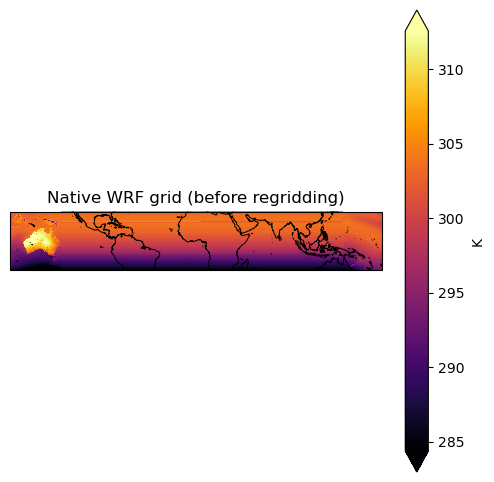

In [14]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Native grid (before regridding)
tasmax_native = ds["tasmax"].isel(time=0)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

tasmax_native.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="inferno",
    robust=True,
    cbar_kwargs={"label": tasmax_native.attrs.get("units", "K")}
)

ax.coastlines(resolution="50m", linewidth=0.7)
ax.set_title("Native WRF grid (before regridding)")
plt.show()


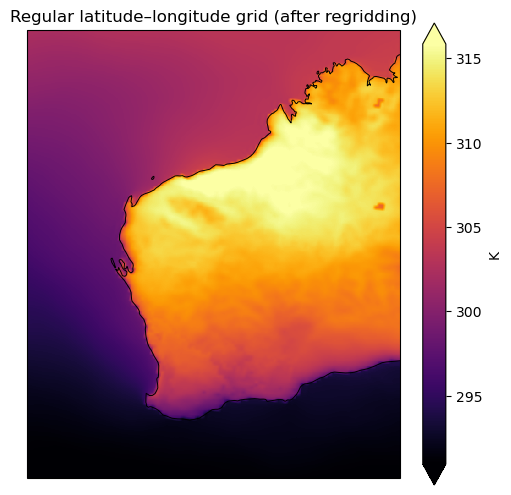

In [13]:
# Regridded output (regular lat–lon grid)
tasmax_regridded = tasmax_rg.isel(time=0)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

tasmax_regridded.plot(
    ax=ax,
    cmap="inferno",
    robust=True,
    cbar_kwargs={"label": tasmax_regridded.attrs.get("units", "K")}
)

ax.coastlines(resolution="50m", linewidth=0.7)
ax.set_title("Regular latitude–longitude grid (after regridding)")
plt.show()


In [7]:
regridded_vars = {}

for var in ds.data_vars:
    da = ds[var]
    if {"rlat", "rlon"}.issubset(da.dims):
        print(f"Regridding {var}")
        regridded_vars[var] = regridder(da)
    else:
        print(f"Skipping {var}")

regridded_ds = xr.Dataset(regridded_vars)
regridded_ds


Regridding tasmax


<xarray.Dataset> Size: 11MB
Dimensions:  (time: 12, lat: 530, lon: 440)
Coordinates:
  * time     (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T12:...
  * lat      (lat) float64 4kB -38.5 -38.45 -38.4 -38.35 ... -12.15 -12.1 -12.05
  * lon      (lon) float64 4kB 108.0 108.0 108.1 108.1 ... 129.8 129.9 129.9
    height   float64 8B ...
Data variables:
    tasmax   (time, lat, lon) float32 11MB 290.5 290.5 290.5 ... 303.5 303.5

In [8]:
regridded_ds.attrs.update({
    "title": "Regridded NARCliM 2.0 Data",
    "source": "NARCliM 2.0 via NCI THREDDS",
    "regridding_method": "bilinear",
    "original_grid": "WRF rotated lat-lon (rlat, rlon)",
    "notes": "Regridded to regular latitude–longitude grid for analysis"
})


In [9]:
output_dir = Path("output/regridded")
output_dir.mkdir(parents=True, exist_ok=True)

outfile = output_dir / "tasmax_regridded_wa_0p05deg.nc"
regridded_ds.to_netcdf(outfile)

outfile


PosixPath('output/regridded/tasmax_regridded_wa_0p05deg.nc')

## Downstream Use

This notebook is intentionally limited to spatial transformation only.
The regridded NetCDF outputs produced here are intended to be used as inputs
to downstream notebooks that perform:

- aggregation to NRM regions
- temporal statistics
- visualisation and mapping
- stakeholder-focused summaries

This separation of concerns improves clarity, reproducibility, and maintainability
of the overall analysis workflow.


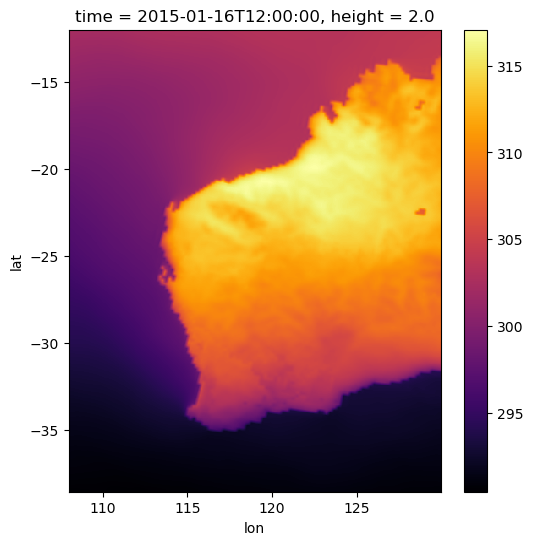

In [10]:
tasmax_rg.isel(time=0).plot(
    figsize=(6, 6),
    cmap="inferno"
)


## Summary

This notebook provides a reproducible example of how to regrid NARCliM 2.0 data
from its native rotated WRF grid to a regular latitude–longitude grid using xESMF.
The resulting datasets form a clean and consistent spatial foundation for
subsequent climate analysis and reporting.
